$\textbf{Proyecto calculo CVA para forwards de tipo de cambio}$  

Alumno: Saavedra Pérez Miguel Rodrigo



In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
from sympy.solvers import solve
from sympy import Symbol
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as tick

#TIPO DE BONO
dayCount="S/A"
#FACTOR DE RECUPERACION
recuperacion=0.25
#FACTOR A RESOLVER
h=0.01
#SIMULACIONES
n=1000

In [2]:
#FUNCION QUE DEVUELVE LA CANTIDAD DE DIAS ENTRE DOS FECHAS BASANDOSE EN UN ANIO DE 360 DIAS (12 MESES DE 30 DIAS)
def dias360(start_date, end_date, method_eu=False):
    start_day = start_date.day
    start_month = start_date.month
    start_year = start_date.year
    end_day = end_date.day
    end_month = end_date.month
    end_year = end_date.year

    if (
        start_day == 31 or
        (
            method_eu is False and
            start_month == 2 and (
                start_day == 29 or (
                    start_day == 28 and
                    start_date.is_leap_year is False
                )
            )
        )
    ):
        start_day = 30

    if end_day == 31:
        if method_eu is False and start_day != 30:
            end_day = 1

            if end_month == 12:
                end_year += 1
                end_month = 1
            else:
                end_month += 1
        else:
            end_day = 30

    return (
        end_day + end_month * 30 + end_year * 360 -
        start_day - start_month * 30 - start_year * 360)

#FUNCION FORMATO GRAFICAS
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif  -1000000 >= tick_val:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

#FUNCION PARA EVALUAR Y CALCULAR EL CVA
def calculo_cva(date, credit, notional, maturity, couponRate, ytm, interbankRate, recuperacion, h):
    #GENERAMOS LISTAS PARA CREAR METRICAS
    Start=[]
    End=[]
    indice=[]
    couponNot=[]
    discountFactor=[]
    discountFactorInterBank=[]
    probaCump=[]
    daysToCoupon=[]
    i=0
    dateInicial=maturity-relativedelta(months=+6)
    #LOOP PARA GENERAR LOS FACTORES DE DESCUENTO
    #LOOP PARA GENERAR LOS FACTORES DE DESCUENTO INTERBANCARIOS
    while date-2*relativedelta(months=+6) < dateInicial:
        indice.append(i)
        Start.append(dateInicial)
        End.append(dateInicial+relativedelta(months=+6))
        daysToCoupon.append(dias360(date, dateInicial+relativedelta(months=+6)))
        if dateInicial+relativedelta(months=+6) <= date:
            discountFactor.append(0.0)
            discountFactorInterBank.append(0.0)
        else:
            discountFactor.append(1/((1+ytm/2)**(dias360(date, dateInicial+relativedelta(months=+6))/180)))
            discountFactorInterBank.append(1/((1+interbankRate/2)**(dias360(date, dateInicial+relativedelta(months=+6))/180)))
        dateInicial=dateInicial-relativedelta(months=+6)
        i += 1
        couponNot.append(couponRate/2*notional)
    indice.append(i)
    #CUPONES Y NOCIONAL 
    couponNot[max(indice)-1]=couponRate/2*notional+100
    #PRECIO SUCIO
    dirtyPrice=sum(np.array(discountFactor[::-1])*np.array(couponNot))
    #INTERESES DEVENGADOS
    accrued=couponNot[0]*((180-sorted(daysToCoupon, reverse=False)[0])/180)
    #PRECIO LIMPIO
    cleanPrice=dirtyPrice-accrued
    #PROBA DE INCUMPLIMIENTO PARA UNA CIERTA H
    [probaCump.append((1-h)**i) for i in indice]
    probaIncump=1-np.array(probaCump)
    #PRECIO RIESGOSO
    riskyPrice=sum(np.array(discountFactorInterBank[::-1])*np.array(couponNot)*np.array(probaCump[1:]))+notional*recuperacion*h*sum(np.array(probaCump[:-1]*np.array(discountFactorInterBank[::-1])))
    #OBJETIVO
    target=(dirtyPrice-riskyPrice)*10000

    #RESOLVEMOS ECUACIÓN DADO EL OBJEIVO
    x = Symbol('x')
    probaCump=[]
    [probaCump.append((1-x)**i) for i in indice]
    h=float(solve((dirtyPrice-(sum(np.array(discountFactorInterBank[::-1])*np.array(couponNot)*np.array(probaCump[1:]))+notional*recuperacion*x*sum(np.array(probaCump[:-1])*np.array(discountFactorInterBank[::-1]))))*10000,x)[0])
    #ACTUALIZAMOS PROBABILIDAD DE INCUMPLIMIENTO
    probaCump=[]
    [probaCump.append((1-h)**i) for i in indice]
    probaCump=np.array(probaCump)
    probaIncump=1-probaCump
    probIncumpAcum90=1-(1-h)**(90/180)

    #ESTABLECEMOS PARAMETROS DEL FORWARD
    subyacente=21.77
    plazo=90
    puntosFwd=4118
    precioFwd=subyacente+puntosFwd/10000
    tasaUsd=0.0078413
    tasaUsdAj=(360/plazo)*np.log(1+tasaUsd*plazo/360)
    tasaImplicitaMxn=((precioFwd/subyacente)*(1+tasaUsd*plazo/360)-1)*(360/plazo)
    tasaImplicitaMxnAj=(360/plazo)*np.log(1+tasaImplicitaMxn*plazo/360)
    volatilidad=0.2
    tamanioPaso=1
    nocional=10000000
    TIIE3m=0.0713

    #SIMULACION DE TRAYECTORIA
    tray=[]
    for i in range(0,n):
        lista=[subyacente]
        for numero in range(plazo):
            lista.append((lista[numero])*(np.exp((tasaImplicitaMxnAj-tasaUsdAj-0.5*volatilidad**2)*(tamanioPaso/360)+volatilidad*(tamanioPaso/360)**0.5*norm.ppf(np.random.random(1))[0])))
        tray.append(lista)

    #SIMULACION DE TRAYECTORIA MTM    
    trayMtm=[]
    for i in range(0,n):
        mtm=[]
        for j in range(plazo+tamanioPaso):
            mtm.append(nocional*(np.array(tray)[i][j]*np.exp((tasaImplicitaMxnAj-tasaUsdAj)*(plazo-j)/360)-precioFwd)*np.exp(-tasaImplicitaMxnAj*(plazo-j)/360))
        trayMtm.append(mtm)
    trayMtm=np.array(trayMtm)

    EPE=[np.mean(trayMtm[:,m][trayMtm[:,m]>=0]) for m in range(1,plazo+tamanioPaso)]
    PFE=[np.percentile(trayMtm[:,m][trayMtm[:,m]>=0], 95) for m in range(1,plazo+tamanioPaso)]

    dfTIIE3m=[1/(1+TIIE3m*91/360)**(n/91) for n in range(1,plazo+tamanioPaso)]
    probaCondicional=[1-(1-h)**(n/180)-(1-(1-h)**((n-1)/180)) for n in range(1,plazo+tamanioPaso)]
    
    #CALCULO DE CVA EPE
    CVA=sum(np.array(EPE)*np.array(dfTIIE3m)*np.array(probaCondicional))
    #PARAMETROS PARA EVALUCION DEL RIESGO DEL CVA 
    strike=precioFwd
    nuevoStrike=precioFwd+2
    mtm=nocional*(nuevoStrike-strike)*np.exp(-tasaImplicitaMxnAj*plazo/360)

    x = Symbol('x')
    #ACTUALIZAMOS NUEVO STRIKE
    nuevoStrike=float(solve(nocional*(x-strike)*np.exp(-tasaImplicitaMxnAj*plazo/360)-CVA, x)[0])
    mtm=nocional*(nuevoStrike-strike)*np.exp(-tasaImplicitaMxnAj*plazo/360)
    
    #CALCULO DE CVA PFE
    CVA_PFE=sum(np.array(PFE)*np.array(dfTIIE3m)*np.array(probaCondicional))

    x = Symbol('x')
    #ACTUALIZAMOS NUEVO STRIKE
    nuevoStrike_PFE=float(solve(nocional*(x-strike)*np.exp(-tasaImplicitaMxnAj*plazo/360)-CVA_PFE, x)[0])
    mtm_PFE=nocional*(nuevoStrike_PFE-strike)*np.exp(-tasaImplicitaMxnAj*plazo/360)

    
    return {
        "subyacente": subyacente,
        "plazo": plazo,
        "tasaUsdAj": tasaUsdAj,
        "tasaImplicitaMxnAj": tasaImplicitaMxnAj,
        "dirtyPrice": dirtyPrice,
        "cleanPrice": cleanPrice,
        "riskyPrice": riskyPrice,
        "cva": CVA,
        "cva_PFE": CVA_PFE,
        "strike": strike,
        "nuevoStrike": nuevoStrike,
        "nuevoStrike_PFE": nuevoStrike_PFE,
        "trayectoria": tray,
        "trayectoriaMtm": trayMtm,
        "EPE": EPE,
        "PFE": PFE,
        "probaCumplimiento": probaCump,
        "probaIncumplimiento": probaIncump,
        "probIncumpAcum90": probIncumpAcum90
    }

Hola, Bienvenido a tu calculadora de CVA para un forward de tipo de cambio.
Primero, ¿cómo te llamas?: miguel
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
miguel,  ¿Te gustaría autocompletar la calculadora? SI/NO si
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
La información autocompletada de tu forward es la siguiente:
Fecha de inicio de tu contrato: 2020-04-04 00:00:00
Emisor de bono: PEMEX
Nocional: 100.0
Madurez: 2027-03-13 00:00:00
Tasa cupón: 6.5%
Yield to maturity: 8.5508%
Tasa libre de riesgo: 0.67%
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Espera un momento...
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-

El precio que pagarías para cubrir el riesgo de crédito de contraparte por el forward pactado con EPE es 266203.7232069007 y con PFE al 95% 670939.1314021486, con las siguient

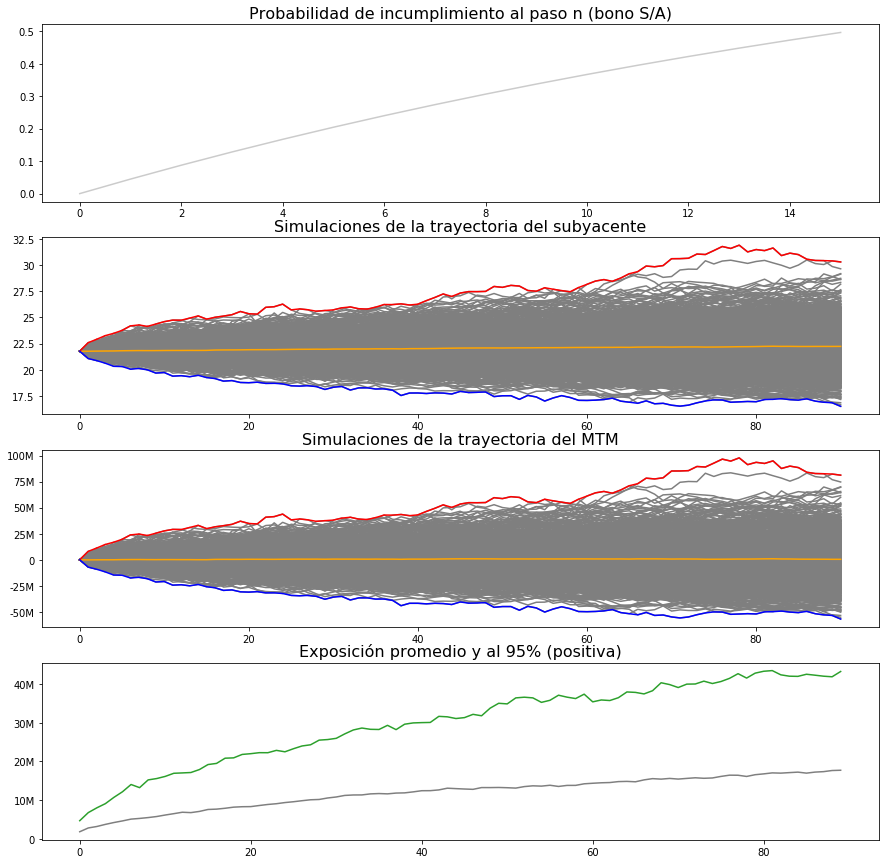

In [3]:
#DEFINIMOS LOS PRIMEROS DATOS PARA EL CALCULO DEL CVA CON EL USUARIO
nombre = input("""Hola, Bienvenido a tu calculadora de CVA para un forward de tipo de cambio.
Primero, ¿cómo te llamas?: """)

des1=input(f"""-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
{nombre},  ¿Te gustaría autocompletar la calculadora? SI/NO """)
des1=des1.lower()

if des1 != "si" and des1 != "no":
    print("""-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Opción no valida. Saliendo del programa""")
elif des1=="si":
    date=datetime(2020, 4, 4, )
    credit="PEMEX"
    notional=100.00
    maturity=datetime(2027, 3, 13, )
    couponRate=0.065
    ytm=0.085508
    interbankRate=0.0067
    print(f"""-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
La información autocompletada de tu forward es la siguiente:
Fecha de inicio de tu contrato: {date}
Emisor de bono: {credit}
Nocional: {notional}
Madurez: {maturity}
Tasa cupón: {couponRate*100}%
Yield to maturity: {ytm*100}%
Tasa libre de riesgo: {interbankRate*100}%
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Espera un momento...
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-""")
else:
    anio=int(input(f"Comencemos {nombre}, ingresa en cuatro digitos el año en que inicial tu contrato: "))
    mes=int(input("Ingresa el/los digito(s) del mes en que inicial tu contrato: "))
    dia=int(input("Ingresa el/los digito(s) del día en que inicial tu contrato: "))           
    date=datetime(anio, mes, dia, )
    credit=input("¿Quién es el emisor del bono (S/A)? ")
    notional=float(input("¿Cuál es su nocional? "))
    anio_m=int(input("""ingresa:
En cuatro digitos el año de madurez de bono: """))
    mes_m=int(input("el/los digito(s) del mes de madurez de bono: "))
    dia_m=int(input("el/los digito(s) del día de madurez de bono: "))
    maturity=datetime(anio_m, mes_m, dia_m, )
    couponRate=float(input("tasa cupón anual de tu bono: "))
    ytm=float(input("yield to maturity anual: "))
    interbankRate=float(input("tasa benchmark libre de riesgo: "))
    print(f"""-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
La información de tu forward es la siguiente:
Fecha de inicio de tu contrato: {date}
Emisor de bono: {credit}
Nocional: {notional}
Madurez: {maturity}
Tasa cupón: {couponRate*100}%
Yield to maturity: {ytm*100}%
Tasa libre de riesgo: {interbankRate*100}%
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Espera un momento...
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-""")
    
d=calculo_cva(date, credit, notional, maturity, couponRate, ytm, interbankRate, recuperacion, h)

print(f"-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-\n-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-\n\nEl precio que pagarías para cubrir el riesgo de crédito de contraparte por el forward pactado con EPE es {d['cva']} y con PFE al 95% {d['cva_PFE']}, con las siguientes condiciones:\n\nSubyacente: {d['subyacente']}\nPlazo: {d['plazo']}\nTasa USD: {d['tasaUsdAj']*100}%\nTasa MXN: {d['tasaImplicitaMxnAj']*100}%\nPrecio Sucio: {d['dirtyPrice']}\nPrecio Limpio: {d['cleanPrice']}\n-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-\n-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-\nte recomendamos reajustar tu strike de {d['strike']} entre {d['nuevoStrike']} y {d['nuevoStrike_PFE']} respecto a los CVA calculados")

fig, ax= plt.subplots(nrows=4, ncols=1, figsize=(15, 15))
ax[0].plot(d["probaIncumplimiento"], alpha=0.4, c="tab:gray")
ax[1].plot(np.array(d["trayectoria"]).T,c="tab:gray")
ax[1].plot(pd.DataFrame((np.array(d["trayectoria"]).T)).mean(axis=1),c="orange", label="Trayectoria promedio")
ax[1].plot(pd.DataFrame((np.array(d["trayectoria"]).T)).max(axis=1),c="red", label="Trayectoria máxima")
ax[1].plot(pd.DataFrame((np.array(d["trayectoria"]).T)).min(axis=1),c="blue", label="Trayectoria mínima")
ax[2].plot(np.array(d["trayectoriaMtm"]).T,c="tab:gray")
ax[2].plot(pd.DataFrame((np.array(d["trayectoriaMtm"]).T)).mean(axis=1),c="orange", label="Trayectoria promedio")
ax[2].plot(pd.DataFrame((np.array(d["trayectoriaMtm"]).T)).max(axis=1),c="red", label="Trayectoria máxima")
ax[2].plot(pd.DataFrame((np.array(d["trayectoriaMtm"]).T)).min(axis=1),c="blue", label="Trayectoria mínima")
ax[0].set_title("Probabilidad de incumplimiento al paso n (bono S/A)", fontsize=16);
ax[1].set_title("Simulaciones de la trayectoria del subyacente", fontsize=16);
ax[2].set_title("Simulaciones de la trayectoria del MTM", fontsize=16);
ax[3].plot(pd.DataFrame(d["EPE"]),c="tab:gray", label="EPE")
ax[3].plot(pd.DataFrame(d["PFE"]),c="tab:green", label="PFE 95%")
ax[3].set_title("Exposición promedio y al 95% (positiva)", fontsize=16);
ax[1].yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax[2].yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax[3].yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));